<a href="https://colab.research.google.com/github/magenta/ddsp/blob/master/ddsp/colab/tutorials/2_processor_group.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


##### Copyright 2021 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");





In [1]:
# Copyright 2021 Google LLC. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# DDSP ProcessorGroup

This notebook demonstrates the use of a `ProcessorGroup()` as an alternative to stringing signal `Processors()` together in python. 

The main advantage of using a ProcessorGroup is that the entire signal processing chain can be specified in a `.gin` file, as a Directed Acyclic Graph (DAG), removing the need to write code in python for every configuration of processors.


In this tutorial we're going to synthesize some audio from these example controls in three different ways.

* With processors and python control flow
* With a ProcessorGroup DAG (via list)
* With a ProcessorGroup DAG (via gin)



In [2]:
#@title Install and import dependencies

%tensorflow_version 2.x
!pip install -qU ddsp

# Ignore a bunch of deprecation warnings
import warnings
warnings.filterwarnings("ignore")

import ddsp
import ddsp.training
from ddsp.colab.colab_utils import play, specplot, DEFAULT_SAMPLE_RATE
import gin
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

sample_rate = DEFAULT_SAMPLE_RATE  # 16000

     |████████████████████████████████| 174kB 12.6MB/s 
     |████████████████████████████████| 3.8MB 23.1MB/s 
     |████████████████████████████████| 215kB 45.0MB/s 
     |████████████████████████████████| 92kB 9.5MB/s 
     |████████████████████████████████| 368kB 54.5MB/s 
     |████████████████████████████████| 5.6MB 1.1MB/s 
     |████████████████████████████████| 61kB 6.6MB/s 


# Example processor inputs

Some signals to be used in the rest of the notebook.

In [3]:
# Constants
n_frames = 1000
hop_size = 64
n_samples = n_frames * hop_size


#### Harmonic controls
# Amplitude [batch, n_frames, 1].
amps = np.linspace(0.5, -5.0, n_frames)[np.newaxis, :, np.newaxis]

# Harmonic Distribution [batch, n_frames, n_harmonics].
n_harmonics = 20
harmonic_distribution = np.ones([n_frames, 1]) * np.linspace(1.0, -1.0, n_harmonics)[np.newaxis, :]
for i in range(n_harmonics):
  harmonic_distribution[:, i] = 1.0 - np.linspace(i * 0.09, 2.0, 1000)
  if i % 2 != 0:
    harmonic_distribution[:, i] = -3
harmonic_distribution = harmonic_distribution[np.newaxis, :, :]

# Fundamental frequency in Hz [batch, n_frames, 1].
f0_hz = np.linspace(300.0, 200.0, n_frames)[np.newaxis, :, np.newaxis]


### Filtered Noise controls
# Magnitudes [batch, n_frames, n_magnitudes].
n_filter_banks = 20
magnitudes = np.linspace(-1.0, -4.0, n_filter_banks)[np.newaxis, np.newaxis, :]
magnitudes = magnitudes + amps 


### Reverb controls
n_fade_in = 16 * 10
ir_size = int(sample_rate * 2)
n_fade_out = ir_size - n_fade_in

ir = 0.01 * np.random.randn(ir_size)
ir[:n_fade_in] *= np.linspace(0.0, 1.0, n_fade_in)
ir[n_fade_in:] *= np.exp(np.linspace(0.0, -5.0, n_fade_out))
ir = ir[np.newaxis, :]


inputs = {
    'amps': amps,
    'harmonic_distribution': harmonic_distribution,
    'f0_hz': f0_hz,
    'magnitudes': magnitudes,
    'ir': ir,
}
inputs = {k: v.astype(np.float32) for k, v in inputs.items()}

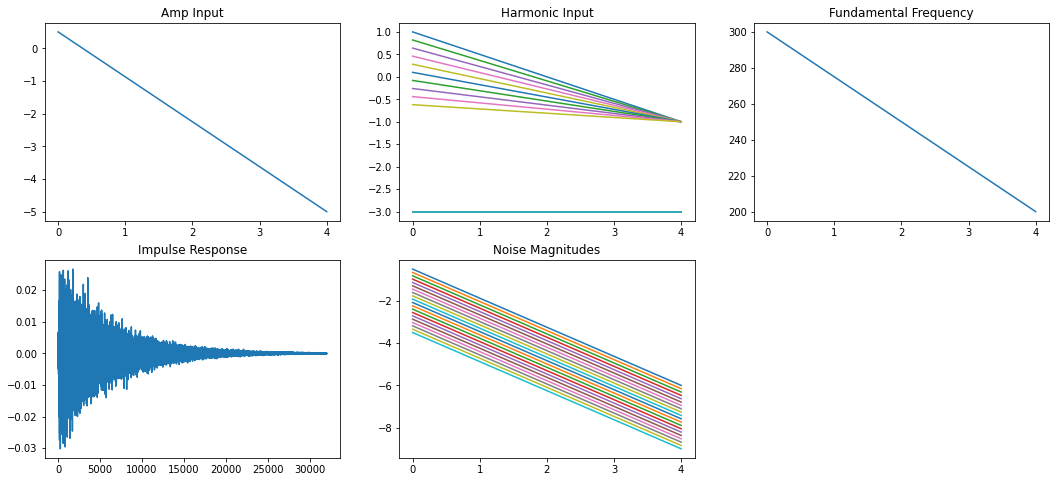

In [4]:
# Plot the inputs
time = np.linspace(0, n_samples / sample_rate, n_frames)

plt.figure(figsize=(18, 8))
plt.subplot(231)
plt.plot(time, amps[0, :, 0])
plt.xticks([0, 1, 2, 3, 4])
plt.title('Amp Input')

plt.subplot(232)
plt.plot(time, harmonic_distribution[0])
plt.xticks([0, 1, 2, 3, 4])
plt.title('Harmonic Input')

plt.subplot(233)
plt.plot(time, f0_hz[0, :, 0])
plt.xticks([0, 1, 2, 3, 4])
plt.title('Fundamental Frequency')

plt.subplot(234)
plt.plot(ir[0])
plt.title('Impulse Response')

plt.subplot(235)
plt.plot(time, magnitudes[0])
plt.xticks([0, 1, 2, 3, 4])
_ = plt.title('Noise Magnitudes')


# Processors

You can generate signal by stringing Processors together in python, as you would with any other differentiable modules.

In [5]:
harmonic = ddsp.synths.Harmonic(n_samples=n_samples)
noise = ddsp.synths.FilteredNoise(n_samples=n_samples, initial_bias=0)
reverb = ddsp.effects.Reverb()

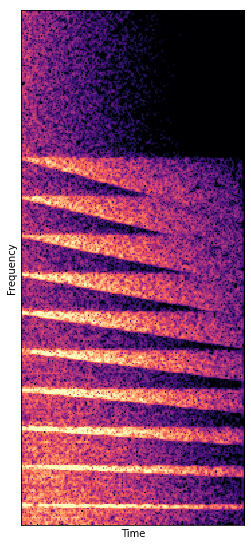

In [6]:
# Python signal processor chain
audio_harmonic = harmonic(inputs['amps'],
                          inputs['harmonic_distribution'],
                          inputs['f0_hz'])
audio_noise = noise(inputs['magnitudes'])
audio_dry = audio_harmonic + audio_noise
audio_out = reverb(inputs['ir'], audio_dry)

# Listen
play(audio_out)
specplot(audio_out)

# ProcessorGroup

A ProcessorGroup is a Directed Acyclic Graph (DAG) of Processors.

You can specify the DAG as a list of tuples `dag = [(processor, ['input1', 'input2', ...]), ...]`, where each tuple is a pair of processor and that processor's inputs respectively.

The output signal of any processor can be referenced as an input to a different processor by the string `'processor_name/signal'` where processor_name is the name of the processor at construction.

The ProcessorGroup takes a dictionary of inputs, whose keys are referenced as inputs in the DAG.


In [7]:
print(inputs.keys())

dict_keys(['amps', 'harmonic_distribution', 'f0_hz', 'magnitudes', 'ir'])


In [8]:
harmonic = ddsp.synths.Harmonic(n_samples=n_samples, name='harmonic')
noise = ddsp.synths.FilteredNoise(n_samples=n_samples, name='noise', initial_bias=0.0)
reverb = ddsp.effects.Reverb(name='reverb')
add = ddsp.processors.Add(name='add')

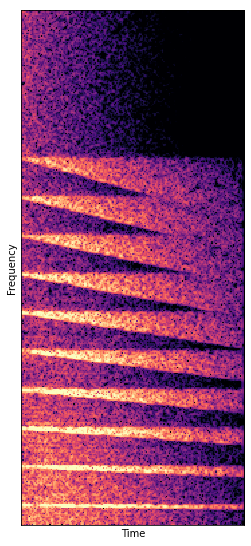

In [9]:
# Processor group DAG
dag = [
  (harmonic, ['amps', 'harmonic_distribution', 'f0_hz']),
  (noise, ['magnitudes']),
  (add, ['harmonic/signal', 'noise/signal']),
  (reverb, ['ir', 'add/signal'])
]

processor_group = ddsp.processors.ProcessorGroup(dag=dag)
audio_out = processor_group(inputs)

# Listen
play(audio_out)
specplot(audio_out)

In [10]:
processor_group.get_controls(inputs)['out']['signal']

<tf.Tensor: shape=(1, 32000), dtype=float32, numpy=
array([[-1.5622936e-07,  1.0071941e-05,  6.5862172e-05, ...,
        -5.3483169e-03, -7.5111812e-04,  2.2530542e-03]], dtype=float32)>

The processor group also offers all the intermediate signals and control tensors for inspection.

In [11]:
outputs = processor_group.get_controls(inputs)

np.set_printoptions(precision=1, threshold=0, edgeitems=1)
for k, v in outputs.items():
  print("'{}':".format(k), v)

'inputs': {'amps': array([[[ 0.5],
        ...,
        [-5. ]]], dtype=float32), 'harmonic_distribution': array([[[ 1., ..., -3.],
        ...,
        [-1., ..., -3.]]], dtype=float32), 'f0_hz': array([[[300.],
        ...,
        [200.]]], dtype=float32), 'magnitudes': array([[[-0.5, ..., -3.5],
        ...,
        [-6. , ..., -9. ]]], dtype=float32), 'ir': array([[ 0.0e+00, ..., -6.4e-05]], dtype=float32)}
'amps': [[[ 0.5]
  ...
  [-5. ]]]
'harmonic_distribution': [[[ 1. ... -3.]
  ...
  [-1. ... -3.]]]
'f0_hz': [[[300.]
  ...
  [200.]]]
'magnitudes': [[[-0.5 ... -3.5]
  ...
  [-6.  ... -9. ]]]
'ir': [[ 0.0e+00 ... -6.4e-05]]
'harmonic': {'signal': <tf.Tensor: shape=(1, 64000), dtype=float32, numpy=array([[4.1e-01, ..., 6.2e-07]], dtype=float32)>, 'controls': {'amplitudes': <tf.Tensor: shape=(1, 1000, 1), dtype=float32, numpy=
array([[[6.7e-01],
        ...,
        [2.0e-05]]], dtype=float32)>, 'harmonic_distribution': <tf.Tensor: shape=(1, 1000, 20), dtype=float32, numpy=
array

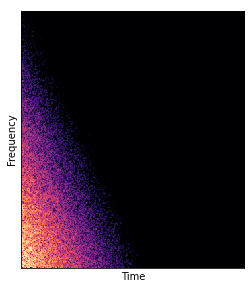

In [12]:
noise_audio = outputs['noise']['signal']
play(noise_audio)
specplot(noise_audio)

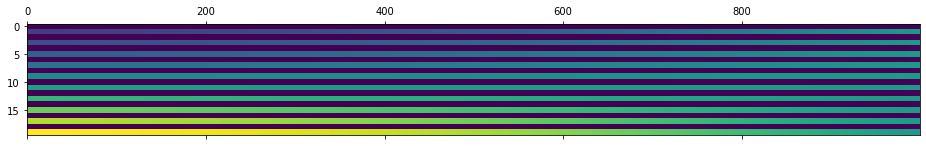

In [13]:
harmonic_distribution_np = outputs['harmonic']['controls']['harmonic_distribution']
_ = plt.matshow(np.rot90(harmonic_distribution_np[0, :, :]), aspect='auto')

# Configuration with Gin

The main advantage of a ProcessorGroup is that it can be defined with Gin, allowing flexible configurations without having to write new python code for every DAG of processors.

In the example below we pretend we have an external file written, which we treat here as a string.

In [14]:
gin_file_string = """
import ddsp

processors.ProcessorGroup.dag = [
  (@Harmonic(), ['amps', 'harmonic_distribution', 'f0_hz']),
  (@FilteredNoise(), ['magnitudes']),
  (@Add(), ['noise/signal', 'harmonic/signal']),
  (@Reverb(), ['ir', 'add/signal'])
]

Harmonic.name = 'harmonic'
FilteredNoise.name = 'noise'
processors.Add.name = 'add'

Harmonic.n_samples = 64000
FilteredNoise.n_samples = 64000
FilteredNoise.initial_bias = 0.0
"""
with gin.unlock_config():
  gin.parse_config(gin_file_string)

Now, after parsing the gin file, the ProcessorGroup will be configured on construction.

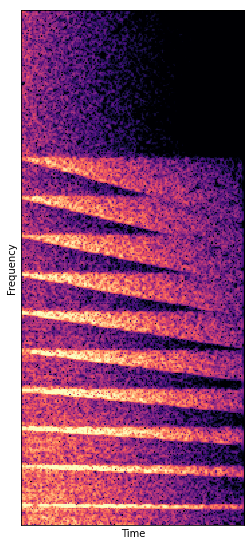

In [15]:
processor_group = ddsp.processors.ProcessorGroup()
audio_out = processor_group(inputs)

# Listen
play(audio_out)
specplot(audio_out)